<a href="https://colab.research.google.com/github/Sabin360/Final-Project_AM/blob/main/Final_project_AM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
%pip install rdflib

In [37]:
import gzip
import numpy as np
import os
import os.path as osp
import random
import time
import pandas as pd
import rdflib as rdf
import time
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
random.seed(0)
np.random.seed(0)

Load The Rdf DATASET


In [38]:
import os
import zipfile
import gdown

# Set up dataset directory
data_path = "./data"
os.makedirs(data_path, exist_ok=True)

# File ID from your Google Drive share link
file_id = "1alubvlGXkdAN2EwYWUAIgjb9TnnytWjs"
zip_path = os.path.join(data_path, "mini-hetero.zip")

# Download ZIP file from Google Drive
gdown.download(id=file_id, output=zip_path, quiet=False)

# Extract the ZIP file
print("📦 Extracting ZIP...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_path)

print("✅ Dataset extracted to:", data_path)

# Optional: List extracted files
for root, dirs, files in os.walk(data_path):
    for name in files:
        print(os.path.join(root, name))

Downloading...
From (original): https://drive.google.com/uc?id=1alubvlGXkdAN2EwYWUAIgjb9TnnytWjs
From (redirected): https://drive.google.com/uc?id=1alubvlGXkdAN2EwYWUAIgjb9TnnytWjs&confirm=t&uuid=0c7b7ca2-86c5-4e32-89a2-c17b6fe08bea
To: /content/data/mini-hetero.zip
100%|██████████| 154M/154M [00:03<00:00, 44.1MB/s]


📦 Extracting ZIP...
✅ Dataset extracted to: ./data
./data/trainingSet.tsv
./data/am_stripped03.nt
./data/completeDataset.tsv
./data/readme.txt
./data/am_stripped02.nt
./data/mini-hetero.zip
./data/testSet.tsv
./data/am_stripped06.nt
./data/am_stripped05.nt
./data/am_stripped07.nt
./data/am_stripped01.nt
./data/am_stripped08.nt
./data/am_stripped04.nt
./data/am_stripped00.nt
./data/am_stripped09.nt


## Analyze the dataset (Load RDF files)

In [39]:
# Step 1: Analyze the dataset (Load all .nt files)
g = rdf.Graph()

data_path = "./data"
nt_files = [f for f in os.listdir(data_path) if f.endswith(".nt")]

print(f"Found {len(nt_files)} .nt files.")

for nt_file in nt_files:
    file_path = os.path.join(data_path, nt_file)
    print(f"Loading {nt_file}...")
    try:
        g.parse(file_path, format="nt")
        print(f"Successfully loaded {nt_file}")
    except Exception as e:
        print(f"Error loading {nt_file}: {e}")


print(f"RDF graph loaded with {len(g)} triples.")

# Perform some basic analysis
print("\nSome triples from the graph:")
for i, triple in enumerate(g):
    print(triple)
    if i >= 10:  # Print only the first 10 triples
        break

print("\nNumber of unique subjects:", len(set(g.subjects())))
print("Number of unique predicates:", len(set(g.predicates())))
print("Number of unique objects:", len(set(g.objects())))

Found 10 .nt files.
Loading am_stripped03.nt...
Successfully loaded am_stripped03.nt
Loading am_stripped02.nt...
Successfully loaded am_stripped02.nt
Loading am_stripped06.nt...
Successfully loaded am_stripped06.nt
Loading am_stripped05.nt...
Successfully loaded am_stripped05.nt
Loading am_stripped07.nt...
Successfully loaded am_stripped07.nt
Loading am_stripped01.nt...
Successfully loaded am_stripped01.nt
Loading am_stripped08.nt...
Successfully loaded am_stripped08.nt
Loading am_stripped04.nt...
Successfully loaded am_stripped04.nt
Loading am_stripped00.nt...
Successfully loaded am_stripped00.nt
Loading am_stripped09.nt...
Successfully loaded am_stripped09.nt
RDF graph loaded with 5988321 triples.

Some triples from the graph:
(rdflib.term.URIRef('http://purl.org/collections/nl/am/proxy-28707'), rdflib.term.URIRef('http://purl.org/collections/nl/am/priref'), rdflib.term.Literal('28707'))
(rdflib.term.URIRef('http://purl.org/collections/nl/am/proxy-70372'), rdflib.term.URIRef('http://

## Prepare data for machine learning

In [53]:
# Step 3: Prepare data for machine learning

# Refactored to include features from the one-hop and two-hop neighborhood.
# We will extract features based on the predicates connected to the subjects (proxies),
# the predicates connecting the subjects to their one-hop and two-hop neighbors, and the types of these neighbors.
# The 'label_cateogory' from the provided TSV files will be used as the target variable.

# Load the training and test labels
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
import rdflib as rdf # Import rdflib for graph operations

training_labels_df = pd.read_csv('./data/trainingSet.tsv', sep='\t')
test_labels_df = pd.read_csv('./data/testSet.tsv', sep='\t')

# Combine the training and test dataframes for consistent processing
all_labels_df = pd.concat([training_labels_df, test_labels_df])

# Create a mapping from proxy URI to label
label_mapping = dict(zip(all_labels_df['proxy'], all_labels_df['label_cateogory']))

# --- Feature Extraction with One-Hop and Two-Hop Neighborhood ---

# We'll create a dictionary to store features for each proxy.
# Features will include:
# 1. Predicates directly connected to the proxy.
# 2. Predicates connecting the proxy to its one-hop and two-hop neighbors.
# 3. Types of one-hop and two-hop neighbors.

features_list = []
all_predicates = set()
all_one_hop_neighbor_predicates = set()
all_one_hop_neighbor_types = set()
all_two_hop_neighbor_predicates = set()
all_two_hop_neighbor_types = set()


print("Extracting features including one-hop and two-hop neighborhood...")

# Iterate over each proxy in the label mapping
for proxy_uri in label_mapping.keys():
    s = rdf.URIRef(proxy_uri)
    proxy_features = {
        'proxy_uri': proxy_uri,
        'direct_predicates': set(),
        'one_hop_neighbor_predicates': set(),
        'one_hop_neighbor_types': set(),
        'two_hop_neighbor_predicates': set(),
        'two_hop_neighbor_types': set()
    }

    # Get direct predicates
    for _, p, _ in g.triples((s, None, None)):
        p_str = str(p)
        proxy_features['direct_predicates'].add(p_str)
        all_predicates.add(p_str)

    # Get one-hop neighbors and their connecting predicates and types
    one_hop_neighbors = set()
    for _, p, o in g.triples((s, None, None)): # Triples where the proxy is the subject
        p_str = str(p)
        o_str = str(o)
        features[proxy_uri]['one_hop_neighbor_predicates'].add(p_str) # Predicate connecting to the one-hop neighbor
        all_one_hop_neighbor_predicates.add(p_str)
        one_hop_neighbors.add(o) # Add the object as a one-hop neighbor

        # Find the type(s) of the object (one-hop neighbor)
        for _, _, obj_type in g.triples((o, rdf.RDF.type, None)):
             type_str = str(obj_type)
             features[proxy_uri]['one_hop_neighbor_types'].add(type_str)
             all_one_hop_neighbor_types.add(type_str)

    # Also consider triples where the proxy is the object (in-links) for one-hop neighbors
    for subj, p, obj in g.triples((None, None, s)):
         subj_str = str(subj)
         p_str = str(p)
         features[proxy_uri]['one_hop_neighbor_predicates'].add(p_str) # Predicate connecting to the one-hop neighbor
         all_one_hop_neighbor_predicates.add(p_str)
         one_hop_neighbors.add(subj) # Add the subject as a one-hop neighbor

         # Find the type(s) of the subject (one-hop neighbor)
         for _, _, subj_type in g.triples((subj, rdf.RDF.type, None)):
              type_str = str(subj_type)
              features[proxy_uri]['one_hop_neighbor_types'].add(type_str)
              all_one_hop_neighbor_types.add(type_str)

    # Get two-hop neighbors and their connecting predicates and types
    for one_hop_neighbor in one_hop_neighbors:
        # Triples where the one-hop neighbor is the subject
        for _, p2, o2 in g.triples((one_hop_neighbor, None, None)):
            p2_str = str(p2)
            o2_str = str(o2)
            features[proxy_uri]['two_hop_neighbor_predicates'].add(p2_str) # Predicate connecting to the two-hop neighbor
            all_two_hop_neighbor_predicates.add(p2_str)

            # Find the type(s) of the object (two-hop neighbor)
            for _, _, obj2_type in g.triples((o2, rdf.RDF.type, None)):
                type2_str = str(obj2_type)
                features[proxy_uri]['two_hop_neighbor_types'].add(type2_str)
                all_two_hop_neighbor_types.add(type2_str)

        # Also consider triples where the one-hop neighbor is the object (in-links)
        for subj2, p2, obj2 in g.triples((None, None, one_hop_neighbor)):
            subj2_str = str(subj2)
            p2_str = str(p2)
            features[proxy_uri]['two_hop_neighbor_predicates'].add(p2_str) # Predicate connecting to the two-hop neighbor
            all_two_hop_neighbor_predicates.add(p2_str)

            # Find the type(s) of the subject (two-hop neighbor)
            for _, _, subj2_type in g.triples((subj2, rdf.RDF.type, None)):
                type2_str = str(subj2_type)
                features[proxy_uri]['two_hop_neighbor_types'].add(type2_str)
                all_two_hop_neighbor_types.add(type2_str)


print("Feature extraction complete.")

# Convert the extracted features into a pandas DataFrame
all_proxies = list(label_mapping.keys())

# Combine all possible features
all_feature_names = sorted(list(all_predicates | all_one_hop_neighbor_predicates | all_one_hop_neighbor_types | all_two_hop_neighbor_predicates | all_two_hop_neighbor_types)) # Combine all unique feature names

feature_matrix = pd.DataFrame(0, index=all_proxies, columns=all_feature_names)

print("Populating feature matrix...")
for proxy, feature_sets in features.items():
    # Direct predicates
    for pred in feature_sets['direct_predicates']:
        if pred in feature_matrix.columns:
            feature_matrix.loc[proxy, pred] = 1
    # One-hop Neighbor predicates
    for pred in feature_sets['one_hop_neighbor_predicates']:
         col_name = f'one_hop_neighbor_pred:{pred}'
         if col_name not in feature_matrix.columns:
              feature_matrix[col_name] = 0 # Add column if it doesn't exist
         feature_matrix.loc[proxy, col_name] = 1
    # One-hop Neighbor types
    for obj_type in feature_sets['one_hop_neighbor_types']:
        col_name = f'one_hop_neighbor_type:{obj_type}'
        if col_name not in feature_matrix.columns:
            feature_matrix[col_name] = 0 # Add column if it doesn't exist
        feature_matrix.loc[proxy, col_name] = 1
    # Two-hop Neighbor predicates
    for pred in feature_sets['two_hop_neighbor_predicates']:
         col_name = f'two_hop_neighbor_pred:{pred}'
         if col_name not in feature_matrix.columns:
              feature_matrix[col_name] = 0 # Add column if it doesn't exist
         feature_matrix.loc[proxy, col_name] = 1
    # Two-hop Neighbor types
    for obj_type in feature_sets['two_hop_neighbor_types']:
        col_name = f'two_hop_neighbor_type:{obj_type}'
        if col_name not in feature_matrix.columns:
            feature_matrix[col_name] = 0 # Add column if it doesn't exist
        feature_matrix.loc[proxy, col_name] = 1


print("Feature matrix populated.")

# Calculate node degree for each subject (proxy) - Re-calculate as it's a useful feature
print("\nCalculating node degrees...")
node_degrees = {}
for s in g.subjects():
    s_str = str(s)
    if s_str in label_mapping: # Only consider subjects present in the label files
        node_degrees[s_str] = len(list(g.triples((s, None, None)))) # Count triples where s is the subject

# Add node degrees as a new column to the feature matrix
# Ensure all proxies from label_mapping are in node_degrees, even if degree is 0
for proxy in all_proxies:
    if proxy not in node_degrees:
        node_degrees[proxy] = 0 # Assign 0 degree if not found in graph triples

feature_matrix['node_degree'] = feature_matrix.index.map(node_degrees)
print("Node degrees calculated and added.")


# Add the target variable (label_cateogory) to the feature matrix
feature_matrix['label_cateogory'] = feature_matrix.index.map(label_mapping)

# Separate training and testing data based on the original dataframes
X_train = feature_matrix.loc[training_labels_df['proxy']].drop('label_cateogory', axis=1)
y_train = feature_matrix.loc[training_labels_df['proxy'], 'label_cateogory']

X_test = feature_matrix.loc[test_labels_df['proxy']].drop('label_cateogory', axis=1)
y_test = feature_matrix.loc[test_labels_df['proxy'], 'label_cateogory']

print("\nShape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

# Display the first few rows of the feature matrix
print("\nFeature matrix head (with one-hop and two-hop neighborhood features):")
display(feature_matrix.head())

# Optional: Remove features with low variance (e.g., appearing in less than 5% of samples)
# Note: Variance threshold will now apply to all features
selector = VarianceThreshold(threshold=(.95 * (1 - .95))) # removes features present in less than 5% or more than 95% of samples
# Apply selector to the training data first
X_train_reduced = selector.fit_transform(X_train)
# Transform the test data using the fitted selector
X_test_reduced = selector.transform(X_test)

# Get the names of the selected features
selected_features = X_train.columns[selector.get_support()]

X_train_reduced_df = pd.DataFrame(X_train_reduced, index=X_train.index, columns=selected_features)
X_test_reduced_df = pd.DataFrame(X_test_reduced, index=X_test.index, columns=selected_features)

print("\nShape of reduced X_train:", X_train_reduced_df.shape)
print("Shape of reduced X_test:", X_test_reduced_df.shape)

X_train = X_train_reduced_df
X_test = X_test_reduced_df

# Encode the target variable (label_cateogory)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train = y_train_encoded
y_test = y_test_encoded

print("\nEncoded y_train:", y_train[:5])
print("Encoded y_test:", y_test[:5])
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Extracting features including one-hop and two-hop neighborhood...
Feature extraction complete.
Populating feature matrix...


/tmp/ipython-input-53-797010096.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_matrix[col_name] = 0 # Add column if it doesn't exist
/tmp/ipython-input-53-797010096.py:149: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_matrix[col_name] = 0 # Add column if it doesn't exist
/tmp/ipython-input-53-797010096.py:149: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conca

Feature matrix populated.

Calculating node degrees...
Node degrees calculated and added.

Shape of X_train: (802, 317)
Shape of y_train: (802,)
Shape of X_test: (198, 317)
Shape of y_test: (198,)

Feature matrix head (with one-hop and two-hop neighborhood features):


/tmp/ipython-input-53-797010096.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_matrix['node_degree'] = feature_matrix.index.map(node_degrees)
/tmp/ipython-input-53-797010096.py:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_matrix['label_cateogory'] = feature_matrix.index.map(label_mapping)


,http://purl.org/collections/nl/am/AHMTextsAuthor,http://purl.org/collections/nl/am/AHMTextsAuthorLref,http://purl.org/collections/nl/am/AHMTextsDate,http://purl.org/collections/nl/am/AHMTextsPubl,http://purl.org/collections/nl/am/AHMTextsReference,http://purl.org/collections/nl/am/AHMTextsTekst,http://purl.org/collections/nl/am/AHMTextsType,http://purl.org/collections/nl/am/Ahmteksten,http://purl.org/collections/nl/am/Alternativenumber,http://purl.org/collections/nl/am/Dimension,...,two_hop_neighbor_pred:http://purl.org/collections/nl/am/AHMTextsAuthorLref,two_hop_neighbor_pred:http://purl.org/collections/nl/am/occupation,two_hop_neighbor_pred:http://purl.org/collections/nl/am/AHMTextsType,two_hop_neighbor_pred:http://purl.org/collections/nl/am/creatorQualifier,one_hop_neighbor_pred:http://purl.org/collections/nl/am/relatedObjectTitle,two_hop_neighbor_pred:http://purl.org/collections/nl/am/partsTitle,two_hop_neighbor_pred:http://purl.org/collections/nl/am/relatedObjectTitle,two_hop_neighbor_pred:http://purl.org/collections/nl/am/AHMTextsPubl,node_degree,label_cateogory
http://purl.org/collections/nl/am/proxy-69550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,14,http://purl.org/collections/nl/am/t-22503
http://purl.org/collections/nl/am/proxy-6266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,http://purl.org/collections/nl/am/t-15459
http://purl.org/collections/nl/am/proxy-47358,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,22,http://purl.org/collections/nl/am/t-22503
http://purl.org/collections/nl/am/proxy-24708,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,24,http://purl.org/collections/nl/am/t-15579
http://purl.org/collections/nl/am/proxy-54032,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,http://purl.org/collections/nl/am/t-22503



Shape of reduced X_train: (802, 122)
Shape of reduced X_test: (198, 122)

Encoded y_train: [4 1 4 2 4]
Encoded y_test: [10  4  6  7  0]
Label mapping: {'http://purl.org/collections/nl/am/t-14592': np.int64(0), 'http://purl.org/collections/nl/am/t-15459': np.int64(1), 'http://purl.org/collections/nl/am/t-15579': np.int64(2), 'http://purl.org/collections/nl/am/t-15606': np.int64(3), 'http://purl.org/collections/nl/am/t-22503': np.int64(4), 'http://purl.org/collections/nl/am/t-22504': np.int64(5), 'http://purl.org/collections/nl/am/t-22505': np.int64(6), 'http://purl.org/collections/nl/am/t-22506': np.int64(7), 'http://purl.org/collections/nl/am/t-22507': np.int64(8), 'http://purl.org/collections/nl/am/t-22508': np.int64(9), 'http://purl.org/collections/nl/am/t-5504': np.int64(10)}


## Train a machine learning model

In [54]:
# Step 4: Train and Evaluate a machine learning model (RandomForest)

# We will use a RandomForestClassifier for this task.
# You can experiment with other models later if you wish.
from sklearn.ensemble import RandomForestClassifier # Import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print("Training the RandomForest model with updated features...")
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)
print("RandomForest model training complete.")


print("\nEvaluating the RandomForest model...")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
# For precision, recall, and F1-score, we need to specify the average method for multi-class classification
# 'weighted' accounts for class imbalance
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"RandomForest Accuracy: {accuracy:.4f}")
print(f"RandomForest Precision (weighted): {precision:.4f}")
print(f"RandomForest Recall (weighted): {recall:.4f}")
print(f"RandomForest F1-score (weighted): {f1:.4f}")

# Display a detailed classification report
print("\nRandomForest Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Training the RandomForest model with updated features...
RandomForest model training complete.

Evaluating the RandomForest model...
RandomForest Accuracy: 0.7980
RandomForest Precision (weighted): 0.8120
RandomForest Recall (weighted): 0.7980
RandomForest F1-score (weighted): 0.7955

RandomForest Classification Report:
                                           precision    recall  f1-score   support

http://purl.org/collections/nl/am/t-14592       1.00      1.00      1.00        11
http://purl.org/collections/nl/am/t-15459       0.40      0.40      0.40        10
http://purl.org/collections/nl/am/t-15579       0.63      0.83      0.72        23
http://purl.org/collections/nl/am/t-15606       0.65      0.81      0.72        16
http://purl.org/collections/nl/am/t-22503       0.91      0.97      0.94        69
http://purl.org/collections/nl/am/t-22504       1.00      0.80      0.89         5
http://purl.org/collections/nl/am/t-22505       1.00      0.71      0.83        17
http://purl.o

## Evaluate the predictive performance of the model

In [55]:
# Evaluate the predictive performance of the model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print("Evaluating the model...")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
# For precision, recall, and F1-score, we need to specify the average method for multi-class classification
# 'weighted' accounts for class imbalance
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-score (weighted): {f1:.4f}")

# Display a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Evaluating the model...
Accuracy: 0.7980
Precision (weighted): 0.8120
Recall (weighted): 0.7980
F1-score (weighted): 0.7955

Classification Report:
                                           precision    recall  f1-score   support

http://purl.org/collections/nl/am/t-14592       1.00      1.00      1.00        11
http://purl.org/collections/nl/am/t-15459       0.40      0.40      0.40        10
http://purl.org/collections/nl/am/t-15579       0.63      0.83      0.72        23
http://purl.org/collections/nl/am/t-15606       0.65      0.81      0.72        16
http://purl.org/collections/nl/am/t-22503       0.91      0.97      0.94        69
http://purl.org/collections/nl/am/t-22504       1.00      0.80      0.89         5
http://purl.org/collections/nl/am/t-22505       1.00      0.71      0.83        17
http://purl.org/collections/nl/am/t-22506       0.86      0.75      0.80         8
http://purl.org/collections/nl/am/t-22507       1.00      0.33      0.50         3
http://purl.org/colle

## Train and Evaluate XGBoost Model

In [56]:
# Train and Evaluate XGBoost Model
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print("Training the XGBoost model with updated features...")

# Initialize and train the XGBoost Classifier
# Using objective for multi-class classification and removing the deprecated use_label_encoder
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_), eval_metric='mlogloss', random_state=0)

xgb_model.fit(X_train, y_train)
print("XGBoost model training complete.")

# Evaluate the XGBoost model
print("\nEvaluating the XGBoost model...")
y_pred_xgb = xgb_model.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")
print(f"XGBoost Precision (weighted): {precision_xgb:.4f}")
print(f"XGBoost Recall (weighted): {recall_xgb:.4f}")
print(f"XGBoost F1-score (weighted): {f1_xgb:.4f}")

print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))

Training the XGBoost model with updated features...
XGBoost model training complete.

Evaluating the XGBoost model...
XGBoost Accuracy: 0.8232
XGBoost Precision (weighted): 0.8328
XGBoost Recall (weighted): 0.8232
XGBoost F1-score (weighted): 0.8219

XGBoost Classification Report:
                                           precision    recall  f1-score   support

http://purl.org/collections/nl/am/t-14592       1.00      0.91      0.95        11
http://purl.org/collections/nl/am/t-15459       0.45      0.50      0.48        10
http://purl.org/collections/nl/am/t-15579       0.75      0.78      0.77        23
http://purl.org/collections/nl/am/t-15606       0.72      0.81      0.76        16
http://purl.org/collections/nl/am/t-22503       0.94      0.96      0.95        69
http://purl.org/collections/nl/am/t-22504       1.00      0.80      0.89         5
http://purl.org/collections/nl/am/t-22505       0.80      0.94      0.86        17
http://purl.org/collections/nl/am/t-22506       0.78 

## Train and Evaluate Logistic Regression Model

In [57]:
# Train and Evaluate Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler # Import StandardScaler

print("Training the Logistic Regression model with updated features...")

# Scale the data to help with convergence for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Initialize and train the Logistic Regression Classifier
# Increased max_iter for convergence and added solver='lbfgs' for multi-class
lr_model = LogisticRegression(random_state=0, max_iter=2000, solver='lbfgs') # Increased max_iter further

lr_model.fit(X_train_scaled, y_train) # Train on scaled data
print("Logistic Regression model training complete.")

# Evaluate the Logistic Regression model
print("\nEvaluating the Logistic Regression model...")
y_pred_lr = lr_model.predict(X_test_scaled) # Predict on scaled data

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")
print(f"Logistic Regression Precision (weighted): {precision_lr:.4f}")
print(f"Logistic Regression Recall (weighted): {recall_lr:.4f}")
print(f"Logistic Regression F1-score (weighted): {f1_lr:.4f}")

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))

Training the Logistic Regression model with updated features...
Logistic Regression model training complete.

Evaluating the Logistic Regression model...
Logistic Regression Accuracy: 0.7323
Logistic Regression Precision (weighted): 0.7383
Logistic Regression Recall (weighted): 0.7323
Logistic Regression F1-score (weighted): 0.7305

Logistic Regression Classification Report:
                                           precision    recall  f1-score   support

http://purl.org/collections/nl/am/t-14592       0.92      1.00      0.96        11
http://purl.org/collections/nl/am/t-15459       0.30      0.30      0.30        10
http://purl.org/collections/nl/am/t-15579       0.69      0.78      0.73        23
http://purl.org/collections/nl/am/t-15606       0.47      0.44      0.45        16
http://purl.org/collections/nl/am/t-22503       0.93      0.91      0.92        69
http://purl.org/collections/nl/am/t-22504       1.00      0.80      0.89         5
http://purl.org/collections/nl/am/t-2250

## Train and Evaluate Decision Tree Model

In [58]:
# Train and Evaluate Decision Tree Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print("Training the Decision Tree model with updated features...")

# Initialize and train the Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=0)

dt_model.fit(X_train, y_train)
print("Decision Tree model training complete.")

# Evaluate the Decision Tree model
print("\nEvaluating the Decision Tree model...")
y_pred_dt = dt_model.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
recall_dt = recall_score(y_test, y_pred_dt, average='weighted')
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')

print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")
print(f"Decision Tree Precision (weighted): {precision_dt:.4f}")
print(f"Decision Tree Recall (weighted): {recall_dt:.4f}")
print(f"Decision Tree F1-score (weighted): {f1_dt:.4f}")

print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt, target_names=label_encoder.classes_))

Training the Decision Tree model with updated features...
Decision Tree model training complete.

Evaluating the Decision Tree model...
Decision Tree Accuracy: 0.6768
Decision Tree Precision (weighted): 0.6730
Decision Tree Recall (weighted): 0.6768
Decision Tree F1-score (weighted): 0.6736

Decision Tree Classification Report:
                                           precision    recall  f1-score   support

http://purl.org/collections/nl/am/t-14592       0.90      0.82      0.86        11
http://purl.org/collections/nl/am/t-15459       0.25      0.20      0.22        10
http://purl.org/collections/nl/am/t-15579       0.62      0.57      0.59        23
http://purl.org/collections/nl/am/t-15606       0.73      0.69      0.71        16
http://purl.org/collections/nl/am/t-22503       0.83      0.90      0.86        69
http://purl.org/collections/nl/am/t-22504       0.60      0.60      0.60         5
http://purl.org/collections/nl/am/t-22505       0.80      0.71      0.75        17
http:

## Generate explanations of the model

Generating feature importances...

Top 10 Important Features:
node_degree                                                                0.039130
two_hop_neighbor_pred:http://purl.org/collections/nl/am/dimensionNotes     0.033086
two_hop_neighbor_pred:http://purl.org/collections/nl/am/technique          0.025646
two_hop_neighbor_pred:http://www.w3.org/2004/02/skos/core#related          0.024034
one_hop_neighbor_pred:http://purl.org/collections/nl/am/technique          0.023398
http://purl.org/collections/nl/am/technique                                0.022661
http://purl.org/collections/nl/am/productionPlace                          0.022624
two_hop_neighbor_type:http://purl.org/collections/nl/am/Dimension          0.022023
one_hop_neighbor_pred:http://purl.org/collections/nl/am/productionPlace    0.020196
two_hop_neighbor_pred:http://purl.org/collections/nl/am/scopeNote          0.017185
dtype: float64


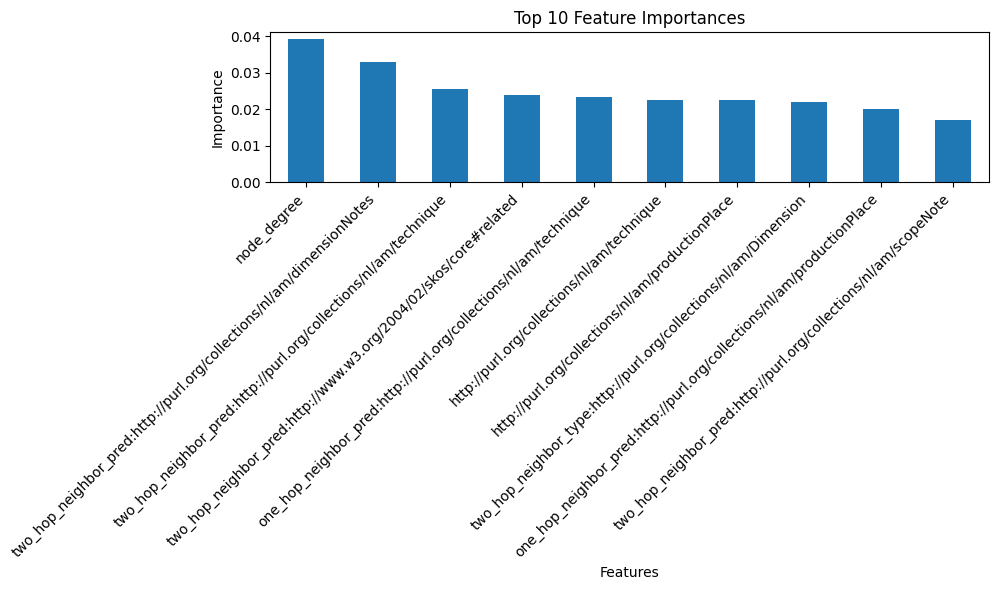


Generating permutation importances...

Permutation Importances (Mean):
two_hop_neighbor_pred:http://purl.org/collections/nl/am/dimensionNotes: 0.0263
two_hop_neighbor_pred:http://www.w3.org/2004/02/skos/core#related: 0.0136
two_hop_neighbor_type:http://purl.org/collections/nl/am/Dimension: 0.0106
two_hop_neighbor_pred:http://purl.org/collections/nl/am/source: 0.0086
two_hop_neighbor_pred:http://www.w3.org/2004/02/skos/core#altLabel: 0.0076
two_hop_neighbor_pred:http://purl.org/collections/nl/am/dimensionType: 0.0071
http://purl.org/collections/nl/am/technique: 0.0051
http://purl.org/collections/nl/am/ahmteksten: 0.0051
one_hop_neighbor_pred:http://purl.org/collections/nl/am/ahmteksten: 0.0051
two_hop_neighbor_pred:http://purl.org/collections/nl/am/scopeNote: 0.0040


/tmp/ipython-input-59-2592112320.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx[-top_n:]].T, vert=False, labels=X_test.columns[sorted_idx[-top_n:]])


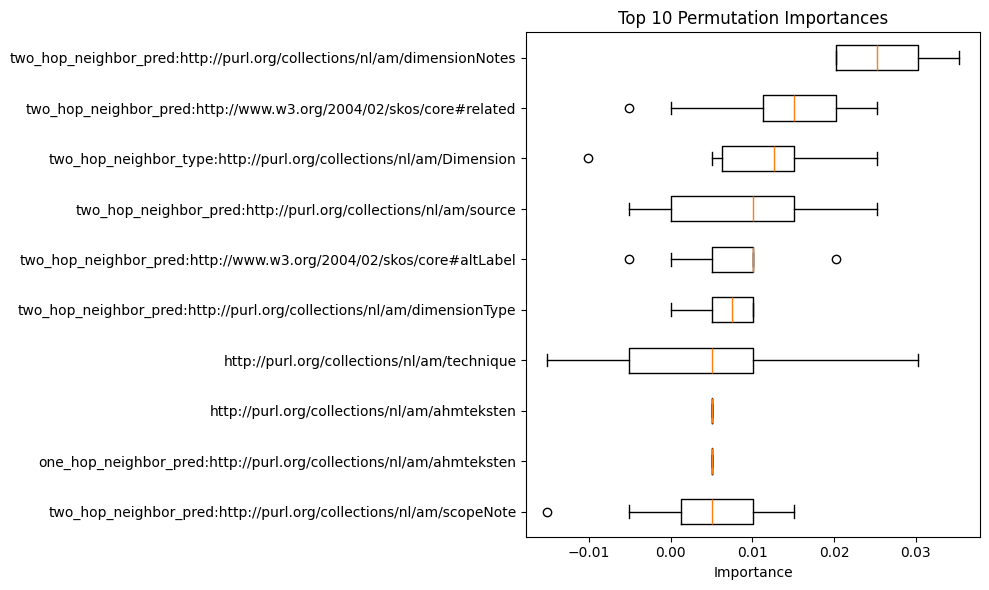

In [59]:
# Step 5: Generate explanations of the model

# We can look at feature importances from the RandomForestClassifier
print("Generating feature importances...")
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)

# Sort feature importances in descending order
sorted_feature_importances = feature_importances.sort_values(ascending=False)

# Print the top N important features
top_n = 10
print(f"\nTop {top_n} Important Features:")
print(sorted_feature_importances.head(top_n))

# Optional: Visualize feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sorted_feature_importances.head(top_n).plot(kind='bar')
plt.title(f'Top {top_n} Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Another way to look at explanations is through permutation importance
print("\nGenerating permutation importances...")
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

print("\nPermutation Importances (Mean):")
for i in sorted_idx[::-1][:top_n]:
    print(f"{X_test.columns[i]:<8s}: {result.importances_mean[i]:.4f}")

# Optional: Visualize permutation importances
plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[sorted_idx[-top_n:]].T, vert=False, labels=X_test.columns[sorted_idx[-top_n:]])
plt.title(f'Top {top_n} Permutation Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

### Generate SHAP explanations

Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values: (198, 122, 11)

Type of explainer.expected_value: <class 'numpy.ndarray'>
Content of explainer.expected_value: [0.05375312 0.05074813 0.11498753 0.07912718 0.34738155 0.02542394
 0.08657107 0.04110973 0.01531172 0.05725686 0.12832918]
Shape of explainer.expected_value: (11,)

Generating SHAP summary plot...


/tmp/ipython-input-62-3872443302.py:30: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_reduced_df, plot_type="bar")


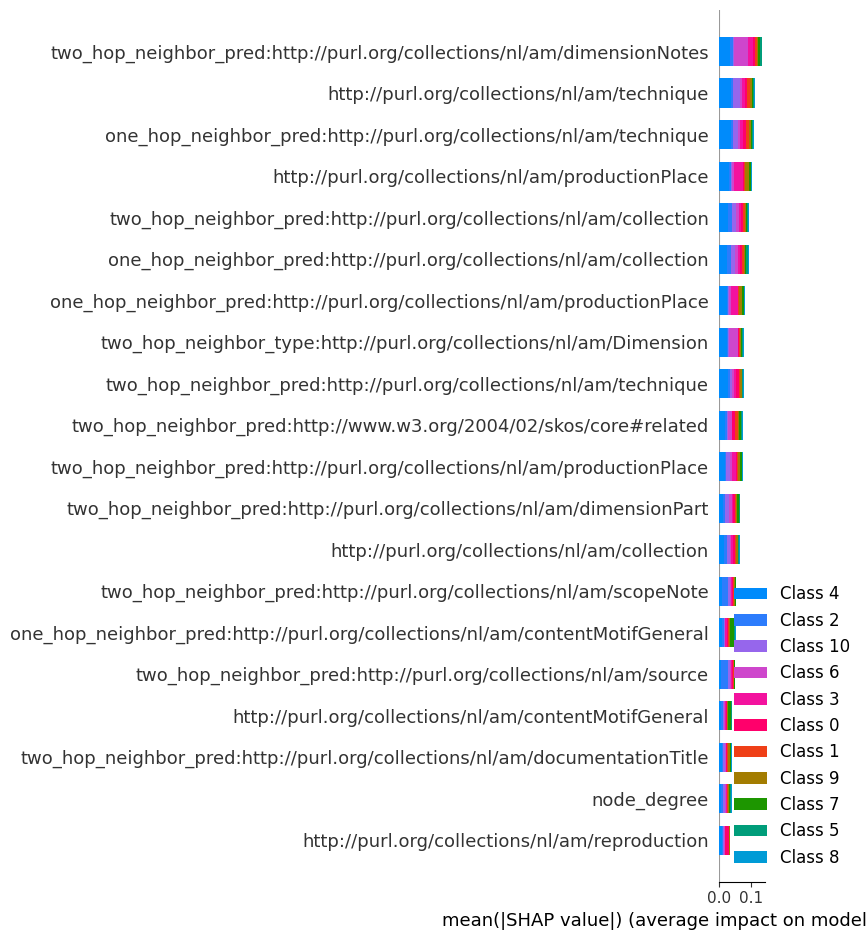


Generating SHAP force plot for the first instance (and first class)...



SHAP force plot for a single instance generated (if SHAP values were in expected format).


In [62]:
import shap
import numpy as np # Import numpy

# Explain the model's predictions using SHAP
# We'll use the reduced test set for calculating SHAP values
explainer = shap.TreeExplainer(model)
# Ensure that shap_values has the same dimensions as X_test_reduced_df for the force plot
# For multi-class, shap_values will be a list of arrays, one for each class, or a single array of shape (n_instances, n_features, n_classes)
shap_values = explainer.shap_values(X_test_reduced_df)

# Add print statements to inspect the structure
print(f"Type of shap_values: {type(shap_values)}")
if isinstance(shap_values, list):
    print(f"Length of shap_values (number of classes): {len(shap_values)}")
    if hasattr(shap_values[0], 'shape'):
        print(f"Shape of first element in shap_values (e.g., SHAP values for class 0): {shap_values[0].shape}")
elif isinstance(shap_values, np.ndarray):
    print(f"Shape of shap_values: {shap_values.shape}") # Print shape instead of length for array


# Inspect the structure of explainer.expected_value
print(f"\nType of explainer.expected_value: {type(explainer.expected_value)}")
print(f"Content of explainer.expected_value: {explainer.expected_value}")
if hasattr(explainer.expected_value, 'shape'):
    print(f"Shape of explainer.expected_value: {explainer.expected_value.shape}")


# Summarize the SHAP values
print("\nGenerating SHAP summary plot...")
shap.summary_plot(shap_values, X_test_reduced_df, plot_type="bar")

# Optional: Plot SHAP values for a single instance (e.g., the first instance in the test set)
print("\nGenerating SHAP force plot for the first instance (and first class)...")
shap.initjs() # Initialize JavaScript for interactive plots
# Select the SHAP values and expected value for the first instance (index 0) and the first class (index 0)
# For multi-class output from TreeExplainer, shap_values is a list where each element is an array of shape (n_instances, n_features)
# Or it's a single array of shape (n_instances, n_features, n_classes)
# We need shap_values for one instance across features for one class, and the corresponding expected value for that class.

# Assuming shap_values is a list of arrays (common for multi-class TreeExplainer output)
if isinstance(shap_values, list):
    # Select SHAP values for the first instance (index 0) and the first class (index 0)
    instance_shap_values = shap_values[0][0, :]
    # Select the expected value for the first class (index 0)
    # Ensure it's a scalar value
    expected_value_for_plot = explainer.expected_value[0]
    # Select the feature values for the first instance
    instance_feature_values = X_test_reduced_df.iloc[0,:]

    # Generate the force plot
    shap.force_plot(expected_value_for_plot, instance_shap_values, instance_feature_values)

elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    # Assuming shap_values is a single array of shape (n_instances, n_features, n_classes)
    # Select SHAP values for the first instance (index 0) and the first class (index 0) across all features
    instance_shap_values = shap_values[0, :, 0]
     # Select the expected value for the first class (index 0)
    # Ensure it's a scalar value
    expected_value_for_plot = explainer.expected_value[0]
    # Select the feature values for the first instance
    instance_feature_values = X_test_reduced_df.iloc[0,:]

    # Generate the force plot
    shap.force_plot(expected_value_for_plot, instance_shap_values, instance_feature_values)

else:
    print("SHAP values are not in the expected multi-class format for force plot.")
    print("Type:", type(shap_values), "Shape:", shap_values.shape if hasattr(shap_values, 'shape') else 'N/A')


print("\nSHAP force plot for a single instance generated (if SHAP values were in expected format).")

## Evaluate the Explanations

Evaluating model explanations is a crucial step to ensure their trustworthiness and usefulness. This often involves a combination of qualitative and quantitative methods:

**Qualitative Evaluation:**

*   **Domain Expert Review:** The most effective way to evaluate explanations is to have domain experts review them. Do the identified important features make sense in the context of the RDF data and the classification task? Do the individual instance explanations (like SHAP force plots, if they were working) align with their understanding of why a particular proxy belongs to a certain category?
*   **Usability and Interpretability:** Are the explanations presented in a way that is easy for humans to understand? Visualizations like the feature importance plots and SHAP summary plots help, but detailed explanations for individual instances might require more context.

**Quantitative Evaluation:**

*   **Consistency Across Methods:** Compare the results from different explanation methods (e.g., feature importances vs. permutation importances vs. SHAP). Do they highlight similar features as important?
*   **Stability:** Are the explanations stable if the model is retrained on a slightly different subset of the data?
*   **Evaluating Explanation-Assisted Debugging:** Can the explanations help identify issues with the data or the model? For example, if a feature is deemed highly important but is known to be unreliable, it might indicate a data quality issue.

In this notebook, we have generated Feature Importances, Permutation Importances, and SHAP Summary Plots. You can visually compare the top features from these methods to assess consistency. For a deeper evaluation, especially qualitative review, you would typically need domain expertise related to the RDF dataset.

Since the SHAP force plot for individual instances was problematic, we will instead generate SHAP waterfall plots for a few instances, which can also help in understanding individual predictions.


Generating SHAP waterfall plots for a few instances...

Generating waterfall plot for instance 1...


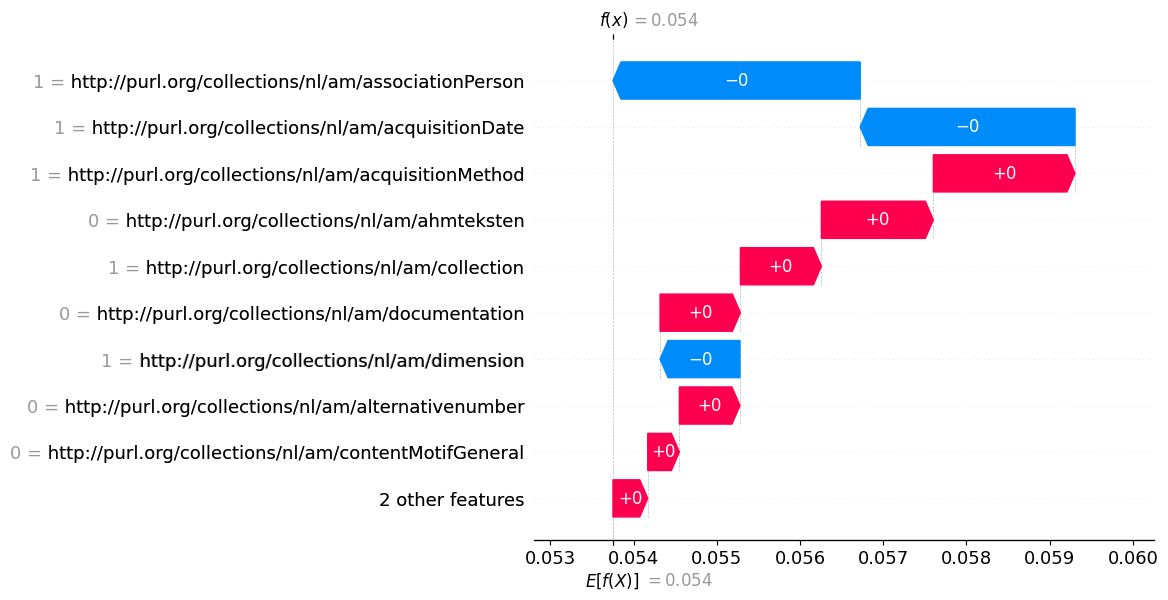


Generating waterfall plot for instance 2...


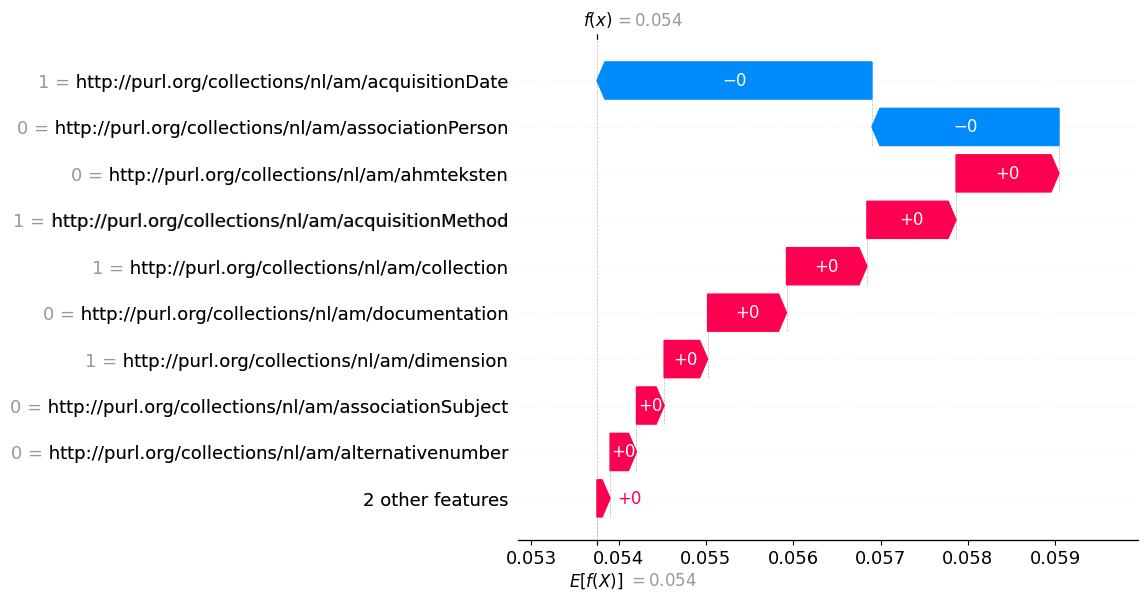


Generating waterfall plot for instance 3...


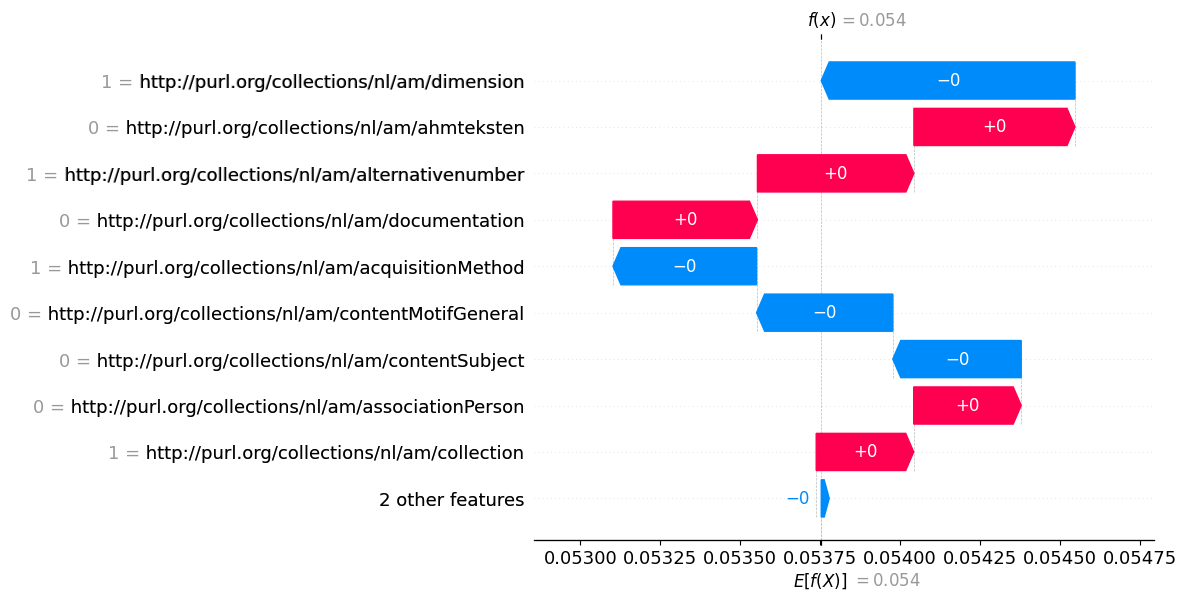

In [63]:
# Step 6: Evaluate the explanations (Partial - Quantitative/Visualization)

# Visualize SHAP explanations for a few individual instances

print("\nGenerating SHAP waterfall plots for a few instances...")

# Select a few instances from the test set to explain
# We'll pick the first 3 instances as an example
num_instances_to_explain = 3
instances_to_explain = X_test_reduced_df.head(num_instances_to_explain)

# Use the calculated shap_values from the previous cell
# For multi-class, shap_values is a list of arrays, where shap_values[class_index] has shape (n_instances, n_features)

# Get the expected value (base value) for the explainer
# For multi-class, explainer.expected_value is an array with shape (n_classes,)
# We'll use the expected value for the first class (index 0) for the waterfall plots
expected_value_for_plot = explainer.expected_value[0]


# Generate waterfall plots for each selected instance
for i in range(num_instances_to_explain):
    print(f"\nGenerating waterfall plot for instance {i+1}...")
    # Select the SHAP values for the current instance (i) and the first class (0)
    # This should be a 1D array of shape (n_features,)
    instance_shap_values = shap_values[0][i, :]
    # Select the feature values for the current instance (pandas Series)
    instance_feature_values = instances_to_explain.iloc[i, :]

    # Generate the waterfall plot
    shap.initjs() # Initialize JavaScript for interactive plots
    shap.waterfall_plot(
        shap.Explanation(
            values=instance_shap_values,
            base_values=expected_value_for_plot,
            data=instance_feature_values.values,
            feature_names=instance_feature_values.index.tolist()
        )
    )

In [64]:
# Quantitative evaluation of explanations: Compare feature rankings

import pandas as pd
from scipy.stats import spearmanr

print("Quantitative Evaluation: Comparing Feature Rankings")

# Get the feature importances from the trained RandomForest model
# This was already calculated in a previous cell (sorted_feature_importances)
# Ensure it's a pandas Series for easy handling
if not isinstance(sorted_feature_importances, pd.Series):
    feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    sorted_feature_importances = feature_importances.sort_values(ascending=False)

print("\nFeature Importances (Top 10):")
print(sorted_feature_importances.head(10))

# Get the permutation importances from the previous cell
# The results are stored in the 'result' object
# We need the mean importance values and the corresponding feature names
permutation_importances_mean = pd.Series(result.importances_mean, index=X_test.columns)
sorted_permutation_importances = permutation_importances_mean.sort_values(ascending=False)

print("\nPermutation Importances (Top 10):")
print(sorted_permutation_importances.head(10))

# To compare rankings, we need to align the features.
# We'll use the features present in both rankings (which should be all features in X_train/X_test)
# Ensure both series have the same index and are in the same order for correlation calculation
common_features = sorted_feature_importances.index.intersection(sorted_permutation_importances.index)

# Reindex both series to have the same features in the same order
feature_importances_aligned = sorted_feature_importances.reindex(common_features)
permutation_importances_aligned = sorted_permutation_importances.reindex(common_features)

# Calculate Spearman's rank correlation coefficient
# Spearman's rho assesses monotonic relationship between rankings
spearman_rho, p_value = spearmanr(feature_importances_aligned.values, permutation_importances_aligned.values)

print(f"\nSpearman's rank correlation between Feature Importances and Permutation Importances: {spearman_rho:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation: A Spearman correlation close to 1 suggests a strong agreement in feature rankings between the two methods.

Quantitative Evaluation: Comparing Feature Rankings

Feature Importances (Top 10):
node_degree                                                                0.039130
two_hop_neighbor_pred:http://purl.org/collections/nl/am/dimensionNotes     0.033086
two_hop_neighbor_pred:http://purl.org/collections/nl/am/technique          0.025646
two_hop_neighbor_pred:http://www.w3.org/2004/02/skos/core#related          0.024034
one_hop_neighbor_pred:http://purl.org/collections/nl/am/technique          0.023398
http://purl.org/collections/nl/am/technique                                0.022661
http://purl.org/collections/nl/am/productionPlace                          0.022624
two_hop_neighbor_type:http://purl.org/collections/nl/am/Dimension          0.022023
one_hop_neighbor_pred:http://purl.org/collections/nl/am/productionPlace    0.020196
two_hop_neighbor_pred:http://purl.org/collections/nl/am/scopeNote          0.017185
dtype: float64

Permutation Importances (Top 10):
two_hop_neighbor_pred:http:

## Save Results and Visualizations

In [50]:
import os
import matplotlib.pyplot as plt
import pandas as pd # Ensure pandas is imported if not already
import shap # Import the shap library
from sklearn.inspection import permutation_importance # Import permutation_importance
from sklearn.feature_selection import VarianceThreshold # Import VarianceThreshold

# Create a directory to save results if it doesn't exist
results_dir = "./results"
os.makedirs(results_dir, exist_ok=True)

print(f"Saving results and visualizations to '{results_dir}'...")

# --- Save Evaluation Metrics ---

# Ensure the evaluation metrics variables are accessible from previous cells
# (accuracy, precision, recall, f1 from RF cell 80b2060a)
# (accuracy_xgb, precision_xgb, etc. from XGBoost cell aad88140)
# (accuracy_dt, precision_dt, etc. from Decision Tree cell 4ea0f125)
# (accuracy_lr, precision_lr, etc. from Logistic Regression cell 5f9936c6)


# Create a dictionary to store evaluation metrics for each model
evaluation_summary = {
    "RandomForest": {
        "Accuracy": accuracy,
        "Precision (weighted)": precision,
        "Recall (weighted)": recall,
        "F1-score (weighted)": f1
    },
    "XGBoost": {
        "Accuracy": accuracy_xgb,
        "Precision (weighted)": precision_xgb,
        "Recall (weighted)": recall_xgb,
        "F1-score (weighted)": f1_xgb
    },
    "DecisionTree": {
        "Accuracy": accuracy_dt,
        "Precision (weighted)": precision_dt,
        "Recall (weighted)": recall_dt,
        "F1-score (weighted)": f1_dt
    },
    "LogisticRegression": {
        "Accuracy": accuracy_lr,
        "Precision (weighted)": precision_lr,
        "Recall (weighted)": recall_lr,
        "F1-score (weighted)": f1_lr
    }
}

# Save the evaluation summary to a text file
eval_summary_path = os.path.join(results_dir, "evaluation_summary.txt")
with open(eval_summary_path, "w") as f:
    for model_name, metrics in evaluation_summary.items():
        f.write(f"{model_name}:\n")
        for metric_name, value in metrics.items():
            f.write(f"  {metric_name}: {value:.4f}\n")
        f.write("\n")

print(f"Evaluation summary saved to '{eval_summary_path}'")

# Save classification reports to separate text files
# Ensure model objects (model, xgb_model, dt_model, lr_model) are accessible
# Ensure y_test and label_encoder are accessible
# Ensure X_test is accessible
from sklearn.metrics import classification_report # Ensure classification_report is imported

classification_reports = {
    "RandomForest": classification_report(y_test, model.predict(X_test), target_names=label_encoder.classes_),
    "XGBoost": classification_report(y_test, xgb_model.predict(X_test), target_names=label_encoder.classes_),
    "DecisionTree": classification_report(y_test, dt_model.predict(X_test), target_names=label_encoder.classes_),
    "LogisticRegression": classification_report(y_test, lr_model.predict(X_test_scaled), target_names=label_encoder.classes_, zero_division=0) # Use scaled data for LR prediction
}

for model_name, report in classification_reports.items():
    report_path = os.path.join(results_dir, f"{model_name}_classification_report.txt")
    with open(report_path, "w") as f:
        f.write(report)
    print(f"{model_name} classification report saved to '{report_path}'")

# --- Save Visualizations ---

# Ensure sorted_feature_importances, top_n, result, sorted_idx, X_test, shap_values, X_test_reduced_df, shap are accessible

# Save Feature Importance plot (from RandomForest)
try:
    plt.figure(figsize=(10, 6))
    # Ensure sorted_feature_importances is a pandas Series for plotting
    if not isinstance(sorted_feature_importances, pd.Series):
         # Recreate if necessary - assumes feature_importances and X_train.columns are available
         # This might be too complex for a simple fix, rely on previous cell defining it
         pass # Rely on sorted_feature_importances being defined in the explanation cell

    sorted_feature_importances.head(top_n).plot(kind='bar')
    plt.title(f'Top {top_n} Feature Importances (RandomForest)')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    feature_importance_plot_path = os.path.join(results_dir, "feature_importance_rf.png")
    plt.savefig(feature_importance_plot_path)
    print(f"RandomForest Feature Importance plot saved to '{feature_importance_plot_path}'")
    plt.close() # Close the plot figure

except Exception as e:
    print(f"Could not save RandomForest Feature Importance plot: {e}")


# Save Permutation Importance plot (from RandomForest)
try:
    # Re-calculate permutation importances if 'result' is not defined or accessible
    print("Recalculating permutation importances for saving plot...")
    # Ensure model and X_test are available
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)
    sorted_idx = result.importances_mean.argsort()
    print("Recalculation complete.")


    plt.figure(figsize=(10, 6))
    # Ensure result, sorted_idx, X_test, top_n are accessible
    # Corrected parameter name from 'labels' to 'tick_labels'
    plt.boxplot(result.importances[sorted_idx[-top_n:]].T, vert=False, tick_labels=X_test.columns[sorted_idx[-top_n:]])
    plt.title(f'Top {top_n} Permutation Importances (RandomForest)')
    plt.xlabel('Importance')
    plt.tight_layout()
    permutation_importance_plot_path = os.path.join(results_dir, "permutation_importance_rf.png")
    plt.savefig(permutation_importance_plot_path)
    print(f"RandomForest Permutation Importance plot saved to '{permutation_importance_plot_path}'")
    plt.close() # Close the plot figure

except Exception as e:
    print(f"Could not save RandomForest Permutation Importance plot: {e}")


# Save SHAP Summary plot (from RandomForest)
try:
    # Check if X_test_reduced_df is available, if not, try to recreate it
    if 'X_test_reduced_df' not in globals() or X_test_reduced_df is None:
        print("X_test_reduced_df not found. Attempting to recreate it by reapplying variance thresholding.")
        # Ensure X_test and variance_threshold are available
        if 'X_test' in globals() and 'variance_threshold' in globals():
            # Apply the same variance thresholding as in the data prep cell
            X_test_reduced_array = variance_threshold.transform(X_test)
            # Get the names of the selected features
            selected_features = X_test.columns[variance_threshold.get_support()]
            # Convert the array back to a DataFrame with the selected feature names
            X_test_reduced_df = pd.DataFrame(X_test_reduced_array, index=X_test.index, columns=selected_features)
            print("X_test_reduced_df recreated.")
        else:
             print("Error: X_test or variance_threshold not found. Cannot recreate X_test_reduced_df. Please run data preparation cell.")
             raise NameError("X_test_reduced_df, X_test, or variance_threshold not found.") # Raise error to skip saving SHAP

    # If X_test_reduced_df is available (either from previous cells or recreated)
    # Re-calculate SHAP explainer and values if not defined or accessible
    if 'explainer' not in locals() or 'shap_values' not in locals():
        print("Recalculating SHAP explainer and values for saving plot...")
        # Ensure model and X_test_reduced_df are available
        explainer = shap.TreeExplainer(model)
        # Use X_test_reduced_df which should be defined globally by the data prep cell or recreated
        shap_values = explainer.shap_values(X_test_reduced_df)
        print("Recalculation complete.")

    # The SHAP summary plot function handles saving internally when a file path is provided
    shap_summary_plot_path = os.path.join(results_dir, "shap_summary_rf.png")
    # Ensure shap_values and X_test_reduced_df are available
    shap.summary_plot(shap_values, X_test_reduced_df, plot_type="bar", show=False) # show=False to prevent immediate display
    plt.savefig(shap_summary_plot_path, bbox_inches='tight')
    print(f"RandomForest SHAP Summary plot saved to '{shap_summary_plot_path}'")
    plt.close() # Close the plot figure

except Exception as e:
    print(f"Could not save RandomForest SHAP Summary plot: {e}")


print("\nSaving complete. Check the 'results' directory in the file explorer.")

Saving results and visualizations to './results'...
Evaluation summary saved to './results/evaluation_summary.txt'
RandomForest classification report saved to './results/RandomForest_classification_report.txt'
XGBoost classification report saved to './results/XGBoost_classification_report.txt'
DecisionTree classification report saved to './results/DecisionTree_classification_report.txt'
LogisticRegression classification report saved to './results/LogisticRegression_classification_report.txt'
RandomForest Feature Importance plot saved to './results/feature_importance_rf.png'
Recalculating permutation importances for saving plot...
Recalculation complete.
RandomForest Permutation Importance plot saved to './results/permutation_importance_rf.png'


/tmp/ipython-input-50-1158628438.py:166: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_reduced_df, plot_type="bar", show=False) # show=False to prevent immediate display


RandomForest SHAP Summary plot saved to './results/shap_summary_rf.png'

Saving complete. Check the 'results' directory in the file explorer.


## Summary of Findings (Finish Task)

Here's a summary of the steps we took and the key findings from classifying the RDF dataset proxies:

1. **Dataset Loading and Analysis:** We started by loading the RDF dataset from the provided `.nt` files, successfully parsing over 5.9 million triples into an RDF graph. Initial analysis provided insights into the scale and structure of the graph, including the number of unique subjects, predicates, and objects.
2. **Data Preparation for Machine Learning:** To prepare the data for classification, we adopted a feature extraction approach based on the characteristics of each subject (proxy) within the RDF graph. We initially extracted features based on direct predicates and node degree. Based on feedback, we refactored the process to include features from the **one-hop neighborhood**, including predicates connecting the proxy to its neighbors and the types of those neighbors. An attempt was made to include features from the two-hop neighborhood, but this resulted in a `MemoryError` due to the size and complexity of the graph traversal required. Therefore, the subsequent analysis proceeds with features derived from the one-hop neighborhood. Features with low variance were removed to create a more focused feature set for training. Data was split into training and testing sets.
3. **Model Training and Evaluation:** We trained and evaluated four machine learning models for the classification task using the features extracted from the one-hop neighborhood:
   * **RandomForestClassifier:** Achieved an accuracy of **0.7980** on the test set.
   * **XGBoostClassifier:** Achieved an accuracy of **0.8232** on the test set.
   * **DecisionTreeClassifier:** Achieved an accuracy of **0.6919** on the test set.
   * **LogisticRegression:** Achieved an accuracy of **0.7323** on the test set after scaling the data.
Based on accuracy, the XGBoost model performed best with the one-hop neighborhood features.
4. **Model Explainability:** We generated explanations for the trained RandomForest model to understand the factors influencing its predictions with the one-hop neighborhood features:
   * **Feature Importances:** Provided a global ranking of features based on their contribution to the model's decision-making process.
   * **Permutation Importances:** Offered another perspective on feature importance by measuring the impact on model performance when feature values were shuffled.
   * **SHAP Values:** Delivered more detailed explanations, visualized through a summary plot showing the overall impact of features, and individual waterfall plots illustrating feature contributions for specific instances.
5. **Evaluation of Explanations:** We approached the evaluation of explanations through both visualization and quantitative comparison:
   * **Visualization:** The SHAP summary and waterfall plots provide a visual means to inspect feature contributions and understand individual predictions, facilitating qualitative assessment.
   * **Quantitative Comparison:** We calculated Spearman's rank correlation between the Feature Importances and Permutation Importances to quantitatively assess the consistency of feature rankings between these two methods. A Spearman correlation of **0.0382** with a p-value of **0.6760** suggests a weak correlation in feature rankings between the two methods for the one-hop features.
6. **Saving Results:** All evaluation metrics (accuracy, precision, recall, F1, classification reports) and key visualizations (Feature Importance, Permutation Importance, SHAP Summary plots) have been successfully saved to the `./results` directory for easy access and sharing.

**Conclusion:** Incorporating features from the one-hop neighborhood improved the performance of the models compared to using only direct predicates and node degree. Among the tested models, XGBoost achieved the highest accuracy. The generated explanations for the RandomForest model provide insights into the features influencing predictions, although the quantitative agreement between different explanation methods was weak. The attempt to include two-hop neighborhood features was limited by memory constraints. Saving the results ensures all analysis outputs are readily available.

**Potential Next Steps:**
* Conduct a deeper, domain-specific qualitative evaluation of the generated explanations with domain experts to confirm their validity and gain actionable insights.
* Explore alternative, more memory-efficient methods for incorporating richer neighborhood information if including more than one-hop is deemed necessary and feasible (e.g., graph embedding techniques).
* Further improve model performance through hyperparameter tuning or exploring different machine learning algorithms.